<a href="https://colab.research.google.com/github/ananthrn/kaggle_submissions/blob/main/playground/Kaggle_playground_s3e26_cirhossis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [130]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import json

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import plot_tree
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.metrics import median_absolute_error, log_loss

import matplotlib.pyplot as plt
import seaborn as sns

import os

from xgboost import XGBRegressor, XGBRFRegressor, XGBClassifier
from sklearn.ensemble import  GradientBoostingClassifier

In [23]:
!mkdir /root/.kaggle
!touch /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [24]:
kaggle_creds = {"username":"ananth360","key":"5b5b919448cff443a5cd24a400cad781"}

with open("/root/.kaggle/kaggle.json","w") as f:
    json.dump(kaggle_creds,f)
!chmod 600 /root/.kaggle/kaggle.json

In [25]:
!kaggle competitions download -c playground-series-s3e26

playground-series-s3e26.zip: Skipping, found more recently modified local copy (use --force to force download)


In [26]:
DATA_NAME = "playground-series-s3e26"

In [27]:
import zipfile
with zipfile.ZipFile(f"./{DATA_NAME}.zip", 'r') as zip_ref:
    zip_ref.extractall(f"./sample_data/{DATA_NAME}")


In [168]:
def get_model_predictions(model, X_train, y_train, test_data, classes = None) -> pd.DataFrame:
    model.fit(X_train, y_train)
    test_predictions = np.array(model.predict_proba(test_data))

    classes = classes or model.classes_
    print("classes: ", classes[0], classes[1], classes[2])
    return pd.DataFrame({
        "id": test_data.index,
        f"status_{classes[0]}": test_predictions[:,0],
        f"status_{classes[1]}": test_predictions[:, 1],
        f"status_{classes[2]}": test_predictions[:,2],
    })

def get_base_rate_predictions(X_train, y_train, test_data) -> pd.DataFrame:

    value_counts = y_train.value_counts()
    test_probs = np.array(value_counts)/len(y_train)

    test_predictions = np.vstack([test_probs] * len(test_data))

    return pd.DataFrame({
        "id": test_data.index,
        f"status_{value_counts.index[0]}": test_predictions[:,0],
        f"status_{value_counts.index[1]}": test_predictions[:, 1],
        f"status_{value_counts.index[2]}": test_predictions[:,2],
    })

def plot_model(model, X_train, y_train) -> pd.DataFrame:
    plt.figure(figsize=(20,20))
    model.fit(X_train, y_train)
    plot_tree(model["clf"])

In [13]:
TRAIN_PATH = f"./sample_data/{DATA_NAME}/train.csv"
TEST_PATH = f"./sample_data/{DATA_NAME}/test.csv"

In [14]:
train_data = pd.read_csv(TRAIN_PATH, index_col="id")
test_data = pd.read_csv(TEST_PATH, index_col="id")

In [17]:
train_data.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
id,,,,,,,,,,,,,,,,,,,
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [18]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7905 entries, 0 to 7904
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         7905 non-null   int64  
 1   Drug           7905 non-null   object 
 2   Age            7905 non-null   int64  
 3   Sex            7905 non-null   object 
 4   Ascites        7905 non-null   object 
 5   Hepatomegaly   7905 non-null   object 
 6   Spiders        7905 non-null   object 
 7   Edema          7905 non-null   object 
 8   Bilirubin      7905 non-null   float64
 9   Cholesterol    7905 non-null   float64
 10  Albumin        7905 non-null   float64
 11  Copper         7905 non-null   float64
 12  Alk_Phos       7905 non-null   float64
 13  SGOT           7905 non-null   float64
 14  Tryglicerides  7905 non-null   float64
 15  Platelets      7905 non-null   float64
 16  Prothrombin    7905 non-null   float64
 17  Stage          7905 non-null   float64
 18  Status  

<Axes: xlabel='Status', ylabel='count'>

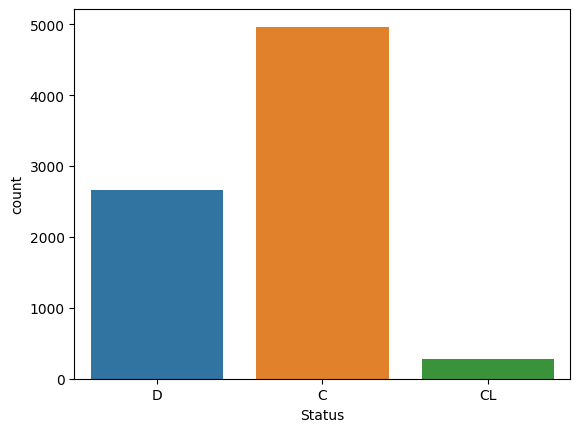

In [35]:
sns.countplot(data=train_data, x="Status")

In [36]:
X, y = train_data.drop(columns=["Status"]), train_data["Status"]

In [124]:
numerical_columns = X.select_dtypes(include=["float64", "int64"]).columns
categorical_columns = X.select_dtypes(include=["object"]).columns

num_pipeline = Pipeline([
    ("log_transform", FunctionTransformer(np.log1p)),
    # ("scaler", StandardScaler())
],
    verbose=True,
)

categorical_pipeline = Pipeline(
    [
        ("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
    ],
    verbose = True,
)

preprocessor = ColumnTransformer([
    ("num", num_pipeline, numerical_columns),
    ("cat", categorical_pipeline, categorical_columns)
],
verbose=True,
)

dec_tree_clf = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clf", DecisionTreeClassifier(max_depth = 4, min_samples_split=10, random_state=42))
    ],
    verbose=True
)



In [125]:
cv_dec_tree_clf_preds = cross_val_predict(dec_tree_clf, X, y, cv=5,)
cv_dec_tree_clf_probs = cross_val_predict(dec_tree_clf, X, y, cv=5, method="predict_proba")

[Pipeline] ..... (step 1 of 1) Processing log_transform, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.1s
[Pipeline] ..... (step 1 of 1) Processing log_transform, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.1s
[Pipeline] ..... (step 1 of 1) Processing log_transform, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipel

In [126]:
print("Classification Report: ")
print(classification_report(y, cv_dec_tree_clf_preds))
print()


print("LogLoss: ")
print(log_loss(y, cv_dec_tree_clf_probs))

Classification Report: 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           C       0.81      0.91      0.86      4965
          CL       0.00      0.00      0.00       275
           D       0.76      0.65      0.70      2665

    accuracy                           0.79      7905
   macro avg       0.52      0.52      0.52      7905
weighted avg       0.76      0.79      0.77      7905


LogLoss: 
0.5517702031190038


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Pipeline] ..... (step 1 of 1) Processing log_transform, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.0s


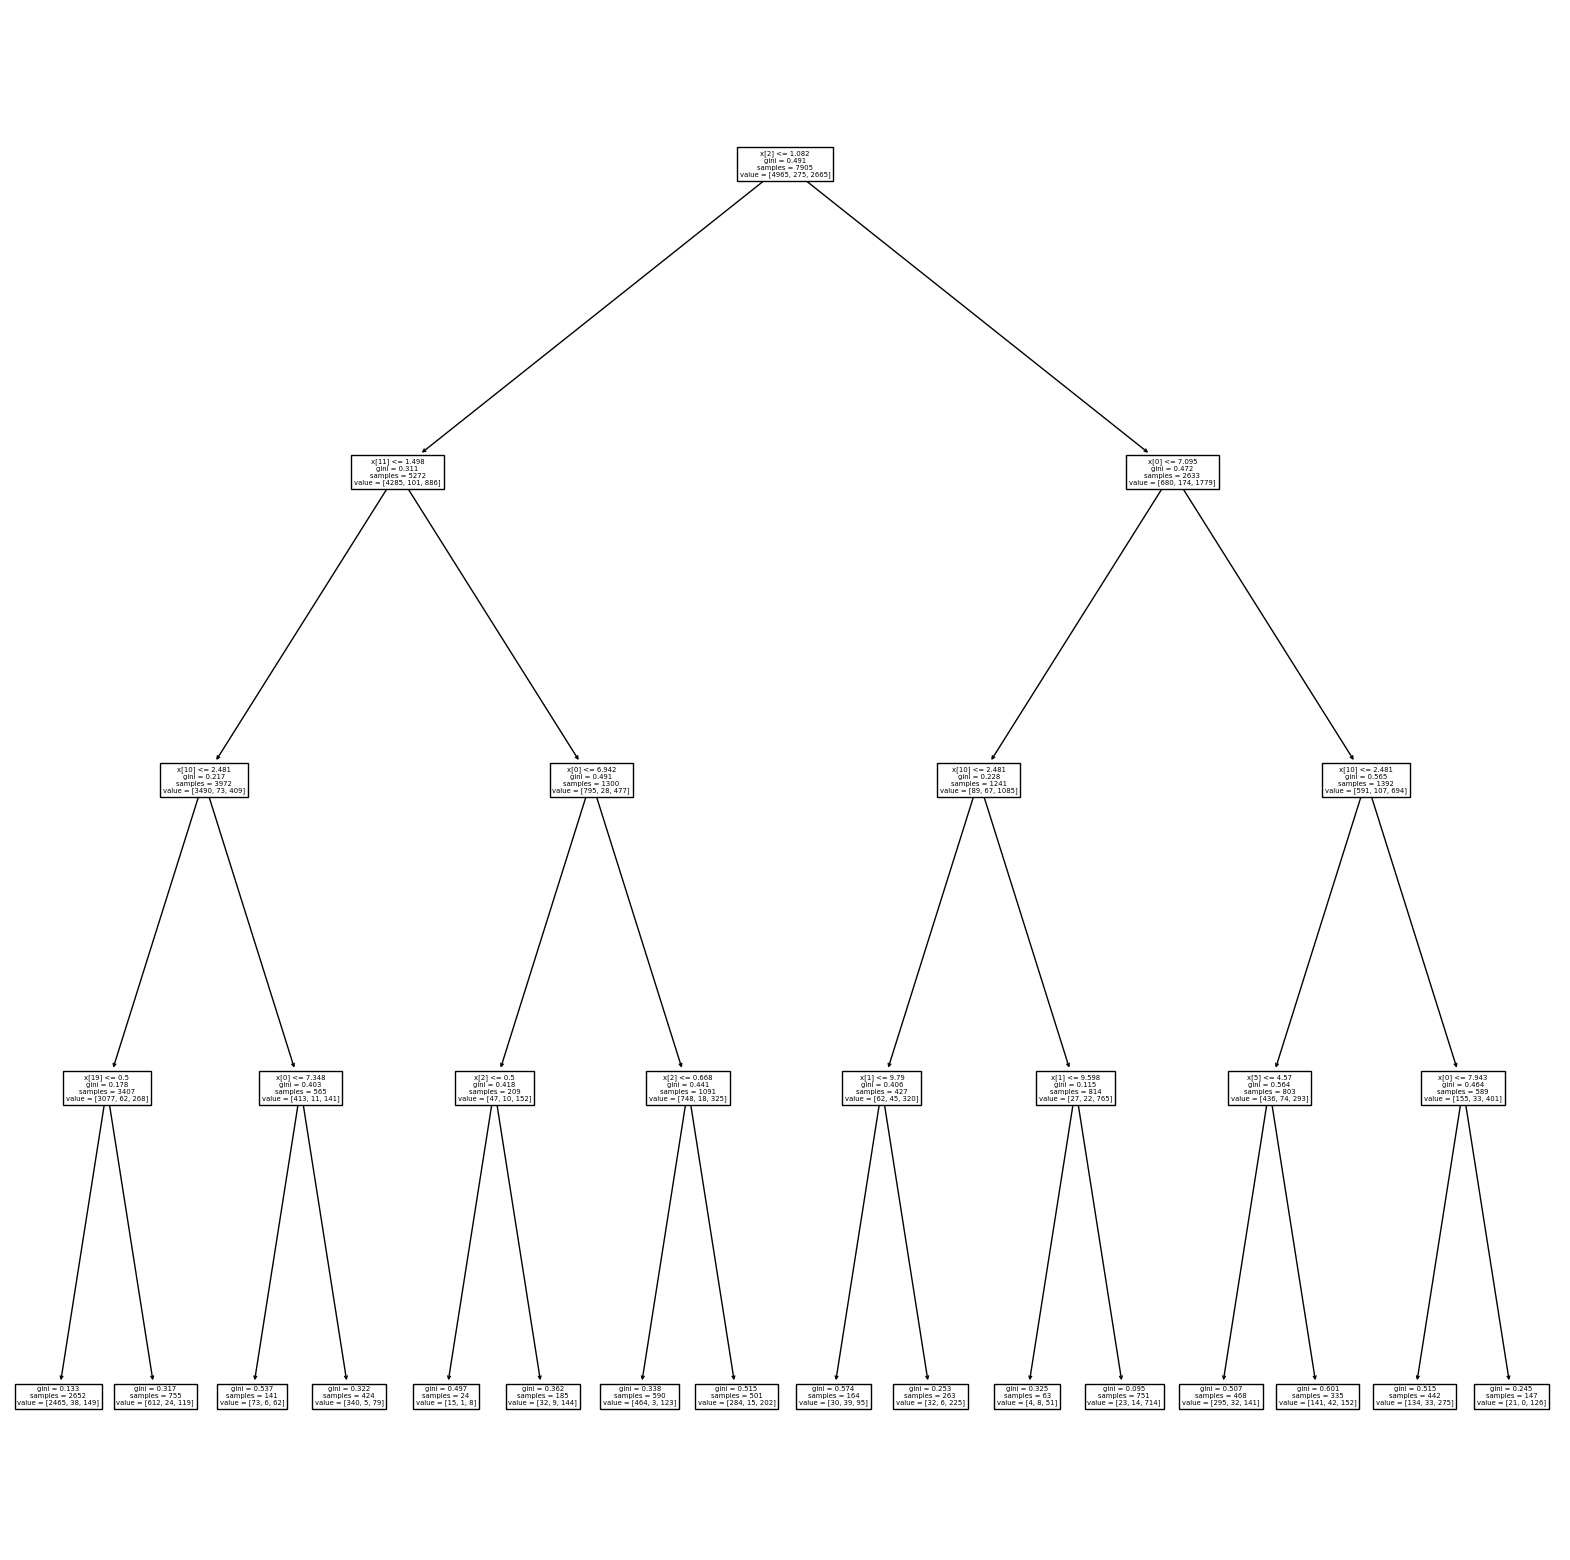

In [139]:
plot_model(dec_tree_clf, X, y)

In [127]:
sub_df = get_model_predictions(dec_tree_clf, X, y, test_data)
sub_df.to_csv(f"./sample_data/{DATA_NAME}/submission_dec_tree_clf.csv", index=False)

[Pipeline] ..... (step 1 of 1) Processing log_transform, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.0s
classes:  C CL D


In [128]:
sub_df.head()

,id,status_C,status_CL,status_D
0,7905,0.810596,0.031788,0.157616
1,7906,0.929487,0.014329,0.056184
2,7907,0.063492,0.126984,0.809524
3,7908,0.929487,0.014329,0.056184
4,7909,0.810596,0.031788,0.157616


In [129]:
!kaggle competitions submit -c playground-series-s3e26 -f ./sample_data/playground-series-s3e26/submission_dec_tree_clf.csv -m "Dec tree depth 4 submission"

100% 332k/332k [00:02<00:00, 143kB/s] 
Successfully submitted to Multi-Class Prediction of Cirrhosis Outcomes

In [116]:
value_counts = y.value_counts()
test_probs = np.array(value_counts)/len(y)
test_base_rate_predictions = np.vstack([test_probs] * len(y))

print("Log Loss of Base rate prediction: ", log_loss(y, test_base_rate_predictions,))

Log Loss of Base rate prediction:  1.4621741177566667


In [110]:
test_base_rate_predictions[0:1]

array([[0.62808349, 0.3371284 , 0.03478811]])

In [112]:
value_counts.index

Index(['C', 'D', 'CL'], dtype='object')

In [102]:
sub_base_rate_df = get_base_rate_predictions(X, y, test_data)
sub_base_rate_df.to_csv("./sample_data/playground-series-s3e26/submission_base_rate.csv", index=False)

In [103]:
sub_base_rate_df.head()

,id,status_C,status_D,status_CL
0,7905,0.628083,0.337128,0.034788
1,7906,0.628083,0.337128,0.034788
2,7907,0.628083,0.337128,0.034788
3,7908,0.628083,0.337128,0.034788
4,7909,0.628083,0.337128,0.034788


In [105]:
!kaggle competitions submit -c playground-series-s3e26 -f ./sample_data/playground-series-s3e26/submission_base_rate.csv -m "Submit base rate preiction"

100% 327k/327k [00:02<00:00, 166kB/s]
Successfully submitted to Multi-Class Prediction of Cirrhosis Outcomes

In [157]:
numerical_columns = X.select_dtypes(include=["float64", "int64"]).columns
categorical_columns = X.select_dtypes(include=["object"]).columns

num_pipeline = Pipeline([
    ("log_transform", FunctionTransformer(np.log1p)),
    # ("scaler", StandardScaler())
],
    verbose=True,
)

categorical_pipeline = Pipeline(
    [
        ("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
    ],
    verbose = True,
)

preprocessor = ColumnTransformer([
    ("num", num_pipeline, numerical_columns),
    ("cat", categorical_pipeline, categorical_columns)
],
verbose=True,
)

rf_clf = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clf", RandomForestClassifier(n_estimators=100, max_depth = 4, min_samples_split=10, random_state=42, n_jobs=-1))
    ],
    verbose=True
)



In [158]:
cv_rf_preds = cross_val_predict(rf_clf, X, y, cv=5)
cv_rf_probs = cross_val_predict(rf_clf, X, y, cv=5, method="predict_proba")

[Pipeline] ..... (step 1 of 1) Processing log_transform, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.7s
[Pipeline] ..... (step 1 of 1) Processing log_transform, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.5s
[Pipeline] ..... (step 1 of 1) Processing log_transform, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipel

In [159]:
print("Classification Report: ")
print(classification_report(y, cv_rf_preds))
print()


print("LogLoss: ")
print(log_loss(y, cv_rf_probs))

Classification Report: 
              precision    recall  f1-score   support

           C       0.82      0.93      0.87      4965
          CL       0.00      0.00      0.00       275
           D       0.80      0.67      0.73      2665

    accuracy                           0.81      7905
   macro avg       0.54      0.53      0.53      7905
weighted avg       0.78      0.81      0.79      7905


LogLoss: 
0.5160646777355623


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [148]:
sub_rf_df = get_model_predictions(rf_clf, X, y, test_data)
sub_rf_df.to_csv("./sample_data/playground-series-s3e26/submission_rf.csv", index=False)

[Pipeline] ..... (step 1 of 1) Processing log_transform, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.3s
classes:  C CL D


In [149]:
sub_rf_df.head()

,id,status_C,status_CL,status_D
0,7905,0.770047,0.028112,0.201841
1,7906,0.806498,0.034788,0.158714
2,7907,0.192989,0.047686,0.759325
3,7908,0.909405,0.016729,0.073866
4,7909,0.670880,0.041602,0.287519


In [150]:
!kaggle competitions submit -c playground-series-s3e26 -f ./sample_data/playground-series-s3e26/submission_rf.csv -m "Submit random forest"

100% 332k/332k [00:02<00:00, 157kB/s]
Successfully submitted to Multi-Class Prediction of Cirrhosis Outcomes

In [175]:
numerical_columns = X.select_dtypes(include=["float64", "int64"]).columns
categorical_columns = X.select_dtypes(include=["object"]).columns

num_pipeline = Pipeline([
    ("log_transform", FunctionTransformer(np.log1p)),
    # ("scaler", StandardScaler())
],
    verbose=True,
)

categorical_pipeline = Pipeline(
    [
        ("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
    ],
    verbose = True,
)

preprocessor = ColumnTransformer([
    ("num", num_pipeline, numerical_columns),
    ("cat", categorical_pipeline, categorical_columns)
],
verbose=True,
)

xgb_clf = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clf", XGBClassifier(n_estimators=300, max_depth = 4, min_samples_split=10, random_state=42, n_jobs=-1))
    ],
    verbose=True
)



# xgb_reg = XGBRegressor(n_estimators=500, max_depth=6, random_state=42, eta=0.01)

In [176]:
cv_xgb_preds = cross_val_predict(xgb_clf, X, y.map({"C": 0, "CL": 1, "D": 2}), cv=5)
cv_xgb_probs = cross_val_predict(xgb_clf, X, y.map({"C": 0, "CL": 1, "D": 2}), cv=5, method="predict_proba")

[Pipeline] ..... (step 1 of 1) Processing log_transform, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:41:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


[Pipeline] ............... (step 2 of 2) Processing clf, total=   2.4s
[Pipeline] ..... (step 1 of 1) Processing log_transform, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:41:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.2s
[Pipeline] ..... (step 1 of 1) Processing log_transform, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:41:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.2s
[Pipeline] ..... (step 1 of 1) Processing log_transform, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:41:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


[Pipeline] ............... (step 2 of 2) Processing clf, total=  25.7s
[Pipeline] ..... (step 1 of 1) Processing log_transform, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:41:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


[Pipeline] ............... (step 2 of 2) Processing clf, total=   3.2s
[Pipeline] ..... (step 1 of 1) Processing log_transform, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:41:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.2s
[Pipeline] ..... (step 1 of 1) Processing log_transform, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:41:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.2s
[Pipeline] ..... (step 1 of 1) Processing log_transform, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:41:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.2s
[Pipeline] ..... (step 1 of 1) Processing log_transform, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:41:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.2s
[Pipeline] ..... (step 1 of 1) Processing log_transform, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:41:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


[Pipeline] ............... (step 2 of 2) Processing clf, total=   4.3s


In [177]:
print("XGBoost Classification Report: ")
print(classification_report(y.map({"C": 0, "CL": 1, "D": 2}), cv_xgb_preds))
print()


print("XGBoost LogLoss: ")
print(log_loss(y.map({"C": 0, "CL": 1, "D": 2}), cv_xgb_probs))

XGBoost Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4965
           1       0.58      0.20      0.29       275
           2       0.79      0.74      0.77      2665

    accuracy                           0.83      7905
   macro avg       0.74      0.62      0.65      7905
weighted avg       0.82      0.83      0.82      7905


XGBoost LogLoss: 
0.5396184167800936


In [178]:
sub_xgb_df = get_model_predictions(xgb_clf, X, y.map({"C": 0, "CL": 1, "D": 2}), test_data, classes=["C", "CL", "D"])
sub_xgb_df.to_csv("./sample_data/playground-series-s3e26/submission_xgb_v2.csv", index=False)

[Pipeline] ..... (step 1 of 1) Processing log_transform, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:42:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


[Pipeline] ............... (step 2 of 2) Processing clf, total=  19.0s
classes:  C CL D


In [179]:
sub_xgb_df.head()

,id,status_C,status_CL,status_D
0,7905,0.087203,0.009158,0.903639
1,7906,0.543577,0.144467,0.311956
2,7907,0.003168,0.000294,0.996538
3,7908,0.981847,0.000487,0.017666
4,7909,0.966803,0.005525,0.027671


In [180]:
!kaggle competitions submit -c playground-series-s3e26 -f ./sample_data/playground-series-s3e26/submission_xgb_v2.csv -m "Submit XGBoost v2 300 estimators"

100% 209k/209k [00:01<00:00, 119kB/s] 
Successfully submitted to Multi-Class Prediction of Cirrhosis Outcomes

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10407 entries, 0 to 10406
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     10407 non-null  float64
 1   density_Total          10407 non-null  float64
 2   allelectrons_Average   10407 non-null  float64
 3   val_e_Average          10407 non-null  float64
 4   atomicweight_Average   10407 non-null  float64
 5   ionenergy_Average      10407 non-null  float64
 6   el_neg_chi_Average     10407 non-null  float64
 7   R_vdw_element_Average  10407 non-null  float64
 8   R_cov_element_Average  10407 non-null  float64
 9   zaratio_Average        10407 non-null  float64
 10  density_Average        10407 non-null  float64
 11  Hardness               10407 non-null  float64
dtypes: float64(12)
memory usage: 1.0 MB


In [ ]:
lin_reg_clf = Pipeline([
    ("log_transform", FunctionTransformer(np.log1p)),
    ("scaler", StandardScaler()),
    ("log_reg", LinearRegression())
])

In [ ]:
cv_lin_reg_preds = cross_val_predict(lin_reg_clf, X, y, cv=10)
print("Median Absolute Error of Linear Regression : ", median_absolute_error(y, cv_lin_reg_preds))

Median Absolute Error of Linear Regression :  1.0304540934976743
